In [2]:
import chardet, torch

with open('hebrew names.txt', 'rb') as file:
    raw_data = file.read()
    detected = chardet.detect(raw_data)
    encoding = detected['encoding']

words = open('hebrew names.txt', 'r', encoding=encoding).read().splitlines()
del words[0]
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?



In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([605729, 4]) torch.Size([605729])
torch.Size([75699, 4]) torch.Size([75699])
torch.Size([75632, 4]) torch.Size([75632])


In [122]:
neuron_layer_size = 100
enc_dim = 3

g = torch.Generator().manual_seed(120) # for reproducibility
C = torch.randn((33, enc_dim), generator=g)
W1 = torch.randn((block_size*enc_dim, neuron_layer_size), generator=g)
b1 = torch.randn(neuron_layer_size, generator=g)
W2 = torch.randn((neuron_layer_size, 33), generator=g)
b2 = torch.randn(33, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [123]:
iter = 1000
lre = torch.linspace(-3, 0, iter)
lrs = 10**lre

In [189]:
lri = []
lossi = []
stepi = []
for i in range(iter):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (128,))
    
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, block_size*enc_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.0000001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

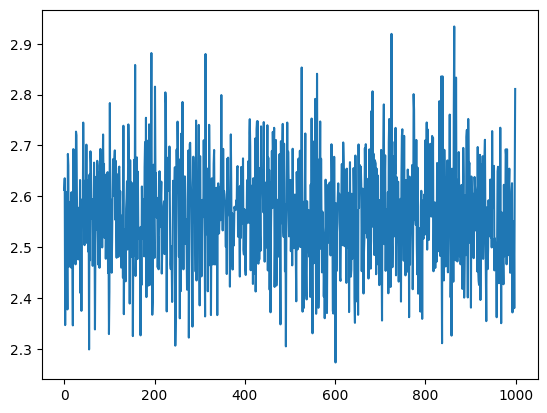

In [190]:
plt.plot(stepi, lossi)

In [191]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size*enc_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5674, grad_fn=<NllLossBackward0>)

In [192]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size*enc_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5702, grad_fn=<NllLossBackward0>)

In [211]:
for _ in range(5):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
          break
      out.append(ix)
    
    print(''.join(itos[i] for i in out))

אאביו
בירנ
סול
סיר
איטמ
